# Diffusion Filters & TV Minimization

In [1]:
import numpy as np
import numba as nb
import cv2
import matplotlib.pyplot as plt
from utils import plots
from utils import imgs

In [3]:
I = cv2.imread('images/chino.png', 0) / 255.0
Istar = cv2.imread('images/chino.png', 0) / 255.0

### Nonlinear diffusion filter using the explicit scheme

In [4]:
def nonlinear_diffusion(I, diff, n=10, tau=0.001):
    u = I.copy()
    r = np.zeros((n, *I.shape))
    for i in range(n):
        uy, ux = np.gradient(u)
        ugrad_norm2 = uy**2 + ux ** 2 
        g = diff(ugrad_norm2)

        gip1 = np.vstack([g[1:], g[-1:]])
        gim1 = np.vstack([g[:1], g[:-1]])

        gjp1 = np.hstack([g[:, 1:], g[:, -1:]])
        gjm1 = np.hstack([g[:, :1], g[:, :-1]])

        uip1 = np.vstack([u[1:], u[-1:]])
        uim1 = np.vstack([u[:1], u[:-1]])

        ujp1 = np.hstack([u[:, 1:], u[:, -1:]])
        ujm1 = np.hstack([u[:, :1], u[:, :-1]])

        giph = (gip1 + g)*.5
        gimh = (gim1 + g)*.5

        gjph = (gjp1 + g)*.5
        gjmh = (gjm1 + g)*.5

        u1 = (1-tau * (giph + gimh + gjph + gjmh)) * u
        u2 = tau * (giph * uip1 + gimh * uim1 + gjph * ujp1 + gjmh * ujm1)
        u = (u1 + u2).copy()
        
        # Save result
        r[i] = u
    return r

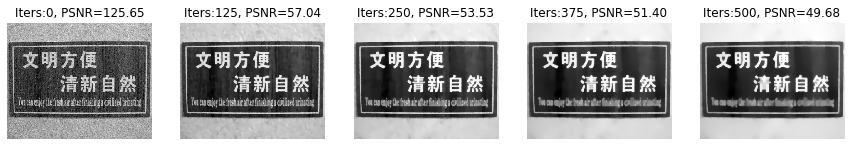

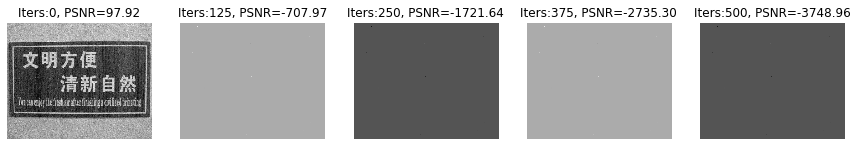

In [6]:

ttvar_diff = lambda s2: 1 / np.sqrt(s2 + 0.001 ** 2)
gauss_diff = lambda s2: np.exp(-s2 / 30.0 ** 2)


res1 = nonlinear_diffusion(I, ttvar_diff, n=101, tau=0.001/4.0)
res2 = nonlinear_diffusion(I, ttvar_diff, n=101, tau=0.001)

show = np.linspace(0, 100, 5, dtype=int)

plots.grid(res1[show], ['Iters:{0}, PSNR={1:.2f}'.format(i, imgs.psnr(res1[i], Istar)) for i in show], 1, 5)
plots.grid(res2[show], ['Iters:{0}, PSNR={1:.2f}'.format(i, imgs.psnr(res2[i], Istar)) for i in show], 1, 5)

### Variational denoising with Gradient Descent

In [38]:
def variational_descent(I, n=100, alpha=15.0, tau=0.001):
    u = I.copy()
    r = np.zeros((n, *I.shape))
    for i in range(n):
        grad = np.stack(np.gradient(u), axis=-1)
        grad = grad / (2 * np.sqrt(grad[:, :, 0]**2 + grad[:, :, 1]**2 + 0.001**2)[:, :, None])
        div  = np.gradient(grad[:, :, 0])[0] + np.gradient(grad[:, :, 1])[1]
        u += tau * (div  - (1/alpha) * (u-I))
        r[i] = u
    return r

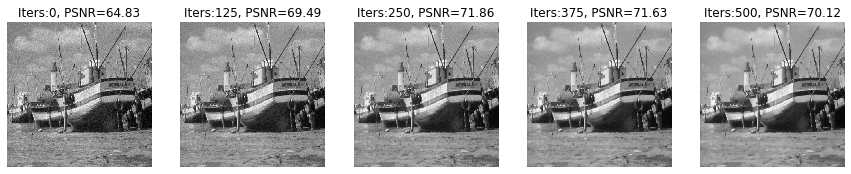

In [40]:
res = variational_descent(I, n=501, alpha=1.0, tau=0.001/4.0)

show = np.linspace(0, 500, 5, dtype=int)
plots.grid(res[show], ['Iters:{0}, PSNR={1:.2f}'.format(i, imgs.psnr(res[i], Istar)) for i in show], 1, 5)